In [1]:
# 04_noisy data, How noisy data can affect our predictions? how can we deal with it?

import numpy as np 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from timeit import default_timer as timer 

# Import modular
%cd ..
import modular.samples_setup as cs
from modular import engine
from modular import model_builder
from modular import extra_functions as ef


/u/ruizsuar/InformedML-CV


#### Simulate data

In [2]:
### Simulate data 
seed = 262
n_samples = [5000]*2

output = cs.generate_sample(n = n_samples, noise_prop = 0,var=0,seed=seed)
images, labels= (output['images'], output['labels'])

# Split test and train
n_test = int(sum(n_samples)*0.2)
test_index = np.arange(n_test)
train_index = np.arange(n_test, sum(n_samples))

images_test = images[test_index]
images_train = images[train_index]

label_test = labels[test_index]
label_train = labels[train_index]

#### No noise

In [3]:
# To reduce variability when re-running 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BATCH_SIZE = 50
EPOCHS = 12
loss_fn = nn.CrossEntropyLoss()

# Create tensor
X_test = torch.from_numpy(images_test).type(torch.float)
X_train = torch.from_numpy(images_train).type(torch.float)

y_train = torch.from_numpy(label_train).type(torch.long)
y_test = torch.from_numpy(label_test).type(torch.long)

## Add channel at dimension 1 (greyscale)
X_train = X_train.unsqueeze(1)  
X_test = X_test.unsqueeze(1)  
        
train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
        
# Create data loader and turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, 
                                batch_size=BATCH_SIZE, 
                                shuffle=False) 
                           
test_dataloader = DataLoader(test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

# Initialize model and optimizer
model_1 =  model_builder.TVGG(input_shape = 1,  
                            hidden_units= 10, 
                            output_shape = 2)
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

output_1 = engine.train_test_loop(model_1,train_dataloader,
                                test_dataloader, optimizer, loss_fn,
                                epochs=EPOCHS,print_b=True)

Epoch: 1 | test_acc: 72.4500
Epoch: 2 | test_acc: 76.0000
Epoch: 3 | test_acc: 76.3500
Epoch: 4 | test_acc: 87.1500
Epoch: 5 | test_acc: 94.2000
Epoch: 6 | test_acc: 97.6000
Epoch: 7 | test_acc: 97.8000
Epoch: 8 | test_acc: 97.8000
Epoch: 9 | test_acc: 97.8000
Epoch: 10 | test_acc: 97.8000
Epoch: 11 | test_acc: 97.9000
Epoch: 12 | test_acc: 97.8000


#### Noise only present in test set

In [ ]:
# Adding noise only to the test set
var =0.15
BATCH_SIZE = 50
EPOCHS = 12
loss_fn = nn.CrossEntropyLoss()

# Create copy of image sets

images_test_e1 = images_test.copy()
images_train_e1 = images_train.copy()

label_test = labels[test_index]
label_train = labels[train_index]

# Add noise        
for i in range(len(images_test)):
        images_test_e1[i] = ef.add_gaussian_noise(images_test_e1[i],
                                               var=var)

# Create tensor
X_test = torch.from_numpy(images_test_e1).type(torch.float)
X_train = torch.from_numpy(images_train_e1).type(torch.float)

y_test = torch.from_numpy(label_test).type(torch.long)
y_train = torch.from_numpy(label_train).type(torch.long)

## Add channel at dimension 1 (greyscale)
X_train = X_train.unsqueeze(1)  
X_test = X_test.unsqueeze(1)  
        
train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
        
# Create data loader and turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, 
                                batch_size=BATCH_SIZE, 
                                shuffle=False) 
                            

test_dataloader = DataLoader(test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

# Initialize model and optimizer
model_2 =  model_builder.TVGG(input_shape = 1,  
                            hidden_units= 10, 
                            output_shape = 2)

optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

output_2 = engine.train_test_loop(model_2,train_dataloader,
                                test_dataloader, optimizer, loss_fn,
                                epochs=EPOCHS,print_b=True)

Epoch: 1 | test_acc: 69.3000
Epoch: 2 | test_acc: 65.6500
Epoch: 3 | test_acc: 65.0500
Epoch: 4 | test_acc: 55.7000
Epoch: 5 | test_acc: 51.3500
Epoch: 6 | test_acc: 54.1000
Epoch: 7 | test_acc: 50.4000
Epoch: 8 | test_acc: 49.9500
Epoch: 9 | test_acc: 49.7000
Epoch: 10 | test_acc: 49.4000
Epoch: 11 | test_acc: 48.8000
Epoch: 12 | test_acc: 49.3500


#### Noise only present in train set

In [8]:
# Adding noise only to the train set
var =0.15
BATCH_SIZE = 50
EPOCHS = 12
loss_fn = nn.CrossEntropyLoss()

# Create copy of image sets

images_test_e2 = images_test.copy()
images_train_e2 = images_train.copy()

label_test = labels[test_index]
label_train = labels[train_index]

# add Gaussian Noise       
for i in range(len(images_test)):
        images_train_e2[i] = ef.add_gaussian_noise(images_train_e2[i],
                                               var=var)

# Create tensor
X_test = torch.from_numpy(images_test_e2).type(torch.float)
X_train = torch.from_numpy(images_train_e2).type(torch.float)

y_test = torch.from_numpy(label_test).type(torch.long)
y_train = torch.from_numpy(label_train).type(torch.long)

## Add channel at dimension 1 (greyscale)
X_train = X_train.unsqueeze(1)  
X_test = X_test.unsqueeze(1)  
        
train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
        
# Create data loader and turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, 
                                batch_size=BATCH_SIZE, 
                                shuffle=False) 
                            

test_dataloader = DataLoader(test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

# Initialize model and optimizer
model_3 =  model_builder.TVGG(input_shape = 1,  
                            hidden_units= 10, 
                            output_shape = 2)

optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

output_3 = engine.train_test_loop(model_3,train_dataloader,
                                test_dataloader, optimizer, loss_fn,
                                epochs=EPOCHS,print_b=True)

Epoch: 1 | test_acc: 71.8500
Epoch: 2 | test_acc: 72.6000
Epoch: 3 | test_acc: 75.7000
Epoch: 4 | test_acc: 76.3000
Epoch: 5 | test_acc: 76.3000
Epoch: 6 | test_acc: 79.8000
Epoch: 7 | test_acc: 88.2000
Epoch: 8 | test_acc: 94.8000
Epoch: 9 | test_acc: 97.0000
Epoch: 10 | test_acc: 97.2000
Epoch: 11 | test_acc: 97.7000
Epoch: 12 | test_acc: 97.7000


3. Now lest assume that we shuffle the data set. So we have noise data in the test and train set. 


In [21]:
var =0.15
BATCH_SIZE = 50
EPOCHS = 12
loss_fn = nn.CrossEntropyLoss()

# Create copy of image sets
images_test_e3 = images_test.copy()
images_train_e3 = images_train.copy()

# add noise to half of them 
n_test_noisy = int(len(images_test)*0.5)
n_train_noisy = int(len(images_train)*0.5)

# add Gaussian Noise       
for i in range(n_test_noisy):
        images_test_e3[i] = ef.add_gaussian_noise(images_test_e3[i],
                                               var=var)
        
for i in range(n_train_noisy):
        images_train_e3[i] = ef.add_gaussian_noise(images_train_e3[i],
                                                var=var)

# Create tensor
X_test = torch.from_numpy(images_test_e3).type(torch.float)
X_train = torch.from_numpy(images_train_e3).type(torch.float)

y_test = torch.from_numpy(label_test).type(torch.long)
y_train = torch.from_numpy(label_train).type(torch.long)

## Add channel at dimension 1 (greyscale)
X_train = X_train.unsqueeze(1)  
X_test = X_test.unsqueeze(1)  
        
train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
        
# Create data loader and turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, 
                                batch_size=BATCH_SIZE, 
                                shuffle=False) 
                            

test_dataloader = DataLoader(test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False)


# Initialize model and optimizer
model_4 =  model_builder.TVGG(input_shape = 1,  
                            hidden_units= 10, 
                            output_shape = 2)

optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

output_4 = engine.train_test_loop(model_4,train_dataloader,
                                test_dataloader, optimizer, loss_fn,
                                epochs=EPOCHS,print_b=True)                        

Epoch: 1 | test_acc: 72.8000
Epoch: 2 | test_acc: 73.9500
Epoch: 3 | test_acc: 74.5500
Epoch: 4 | test_acc: 74.5500
Epoch: 5 | test_acc: 74.6500
Epoch: 6 | test_acc: 74.6000
Epoch: 7 | test_acc: 73.9500
Epoch: 8 | test_acc: 75.3500
Epoch: 9 | test_acc: 81.0000
Epoch: 10 | test_acc: 85.2000
Epoch: 11 | test_acc: 85.3000
Epoch: 12 | test_acc: 85.9500


# OLD VERSION FROM HERE


### Experiment 1

We want to measure the performance of the model when the noise is only present in the 
test data set. Meaning: we trained the model with a good data set and then we want to predict noisy data. 

We vary the total sample size and amout of error. We train the model for each combination and we the assess is performance by getting the test accuracy. 




In [4]:
n_reps = 5
BATCH_SIZE = 32
epochs = 5

n_samples = [[20000]*2, [10000]*2,[5000]*2]
vars = np.array([0,0.05,0.1,0.25])
accuracy_test_e1 = np.zeros((len(n_samples),len(vars),n_reps))

loss_fn = nn.CrossEntropyLoss()

In [9]:
from sklearn.metrics import confusion_matrix


# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

for r in range(n_reps):

    for n in range(len(n_samples)):
        for v in range(len(vars)):
            
            # Start model and optimizer
            model_1 =  classificador(input_shape=1, hidden_units= 10, 
                                    output_shape=2)
            
            optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

            #images, labels = cs.generate_sample(n_samples[n], 0,var=0)
            output = cs.generate_sample(n = n_samples[n], noise_prop = 0,var=0)
            images, labels= (output['images'], output['labels'])
            
            # Split test and train
            n_test = int(sum(n_samples[n])*0.2)
            test_index = np.arange(n_test)
            train_index = np.arange(n_test, sum(n_samples[n]))

            images_test = images[test_index]
            images_train = images[train_index]

            label_test = labels[test_index]
            label_train = labels[train_index]
                    
            # Adding noise only to the test set
                    
            for i in range(len(images_test)):
                    images_test[i] = ef.add_gaussian_noise(images_test[i],
                                                           var=vars[v])
            # Create tensor
            X_test = torch.from_numpy(images_test).type(torch.float)
            X_train = torch.from_numpy(images_train).type(torch.float)

            y_train = torch.from_numpy(label_train).type(torch.long)
            y_test = torch.from_numpy(label_test).type(torch.long)
            
            ## Add channel at dimension 1 (greyscale)
            X_train = X_train.unsqueeze(1)  
            X_test = X_test.unsqueeze(1)  
                    
            train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
            test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
                 
            # Create data loader and turn datasets into iterables (batches)
            train_dataloader = DataLoader(train_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True) 
                                        

            test_dataloader = DataLoader(test_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)
            
            output = engine.train_test_loop(model_1,train_dataloader,
                                            test_dataloader, optimizer, loss_fn,
                                            5,print_b=False)

            accuracy_test_e1[n,v,r] = output['test_acc'][epochs-1]
            
       

KeyboardInterrupt: 

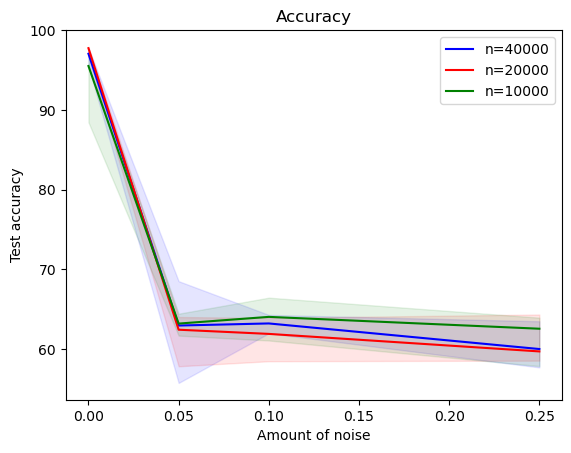

In [44]:
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th, and 90th percentiles
quantile_array = np.quantile(accuracy_test_e1, q=quantiles, axis=2)
quantile_array.shape

colors = np.array(['blue','red','green','orange'])

for i in range(n_samples.shape[0]):

    plt.plot(vars, quantile_array[1,i,], label = f'n={n_samples[i]}', 
             color=colors[i])
    plt.fill_between(vars, quantile_array[0,i,], quantile_array[2,i,], 
                     color=colors[i], alpha=0.1)

plt.xlabel('Amount of noise')
plt.ylabel('Test accuracy')
plt.title('Accuracy')
plt.legend()


## Experiment 2

Now we want to measure the performance of the model when we train the model only with noisy data
Meaning: we train the model with a noisy data set and then we want to predict good data. 

We vary the total sample size and amout of error. We train the model for each combination and we the assess is performance by getting the test accuracy. 



In [27]:
n_reps = 5
BATCH_SIZE = 32
epochs = 5

n_samples = [[20000] *2 , [10000]*2,[5000]*2] # for each class
vars = np.array([0,0.05,0.1,0.25])
accuracy_test_e2 = np.zeros((len(n_samples),len(vars),n_reps))

loss_fn = nn.CrossEntropyLoss()


In [28]:
from sklearn.metrics import confusion_matrix

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

for r in range(n_reps):
    for n in range(len(n_samples)):
        for v in range(len(vars)):
            
            # Start model and optimizer
            model_2 =  classificador(input_shape=1, hidden_units= 10, 
                                     output_shape=2)
            optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

            # Simulate data
            output = cs.generate_sample(n=n_samples[n], noise_prop=0,var=0)
            images = output['images']
            labels = output['labels']
                    
            # Split test and train
            n_test = int(sum(n_samples[n])*0.2)
            test_index = np.arange(n_test)
            train_index = np.arange(n_test, sum(n_samples[n]))

            images_test = images[test_index]
            images_train = images[train_index]

            label_test = labels[test_index]
            label_train = labels[train_index]
                    
            # Add noise only to the train set
            for i in range(len(images_train)):
                images_train[i] = ef.add_gaussian_noise(images_train[i],
                                                        var=vars[v])
            # create tensor
            X_test = torch.from_numpy(images_test).type(torch.float)
            X_train = torch.from_numpy(images_train).type(torch.float)

            y_train = torch.from_numpy(label_train).type(torch.long)
            y_test = torch.from_numpy(label_test).type(torch.long)
            
            ## Add channel at dimension 1 (greyscale)
            X_train = X_train.unsqueeze(1)  
            X_test = X_test.unsqueeze(1)  
                    
            train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
            test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
                    
            # Create data loader and turn datasets into iterables (batches)
            train_dataloader = DataLoader(train_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)
            
            test_dataloader = DataLoader(test_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)
                                        
            output = engine.train_test_loop(model_2,train_dataloader,
                                            test_dataloader, optimizer, loss_fn,
                                            5,print_b=False)

            accuracy_test_e2[n,v,r] = output['test_acc'][epochs-1]
       


In [17]:
# Save the model 
ef.save_model(model = model_2,
                    target_dir = "models",
                    model_name = "model_exp2.pth") 

[INFO] Saving model to: models/model_exp2.pth


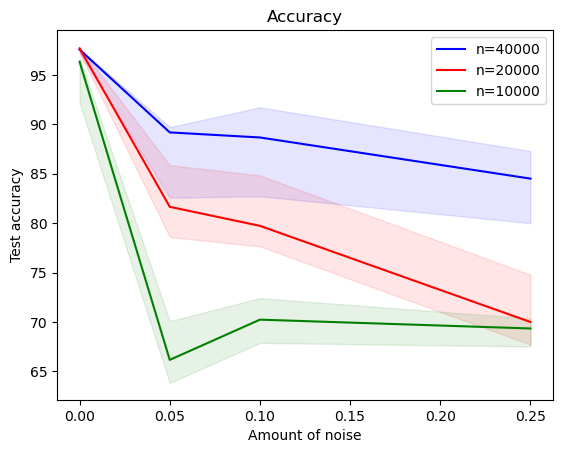

In [43]:
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th, and 90th percentiles
quantile_array = np.quantile(accuracy_test_e2, q=quantiles, axis=2)
quantile_array.shape

colors = np.array(['blue','red','green','orange'])

for i in range(n_samples.shape[0]):

    plt.plot(vars, quantile_array[1,i,], label = f'n={n_samples[i]*2}', 
             color=colors[i])
    plt.fill_between(vars, quantile_array[0,i,], quantile_array[2,i,],
                     color=colors[i], alpha=0.1)


plt.xlabel('Amount of noise')
plt.ylabel('Test accuracy')
plt.title('Accuracy')
plt.legend()


## Experiment 3

Now lest assume that we shuffle the data set. So we have noise data in the test and train set. 

With the error rate fixed, we vary the total sample size and the proportion of noisy data. We train the model for each combination and we the assess is performance by getting the test accuracy. 



Note: Just one realization per scenario

In [4]:

n_reps = 5
BATCH_SIZE = 32
epochs = 5
n_samples = [[20000]*2, [10000]*2,[5000]*2] # for each class
noise_props = np.array([0,0.1,0.35,0.5,0.75,0.90,0.99])

accuracy_test_e3 = np.zeros((len(n_samples),len(noise_props),n_reps))
accuracy_noisy_test_e3 = np.zeros((len(n_samples),len(noise_props),n_reps))
var = 0.25

loss_fn = nn.CrossEntropyLoss()

In [10]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

for r in range(n_reps):
    for n, n_sample in enumerate(n_samples):
        
        n_test = int(2*n_sample*0.2) # 20% for testing
        test_index = np.arange(n_test)
        train_index = np.arange(n_test, n_sample*2)
                        
        for i in range(len(noise_props)):
            model_3 =  classificador(input_shape=1, hidden_units= 10, 
                                     output_shape=2)
            optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)
            
            # images, labels = cs.generate_sample(n_samples[n], noise_props[i], 
            #                                     var=var)
            
            output = cs.generate_sample(n = n_sample, noise_prop= noise_props[i],
                                        var=var,
                                        noise_indx=True)
            images, labels, indx_noise = (output['images'], output['labels'],
                                          output['indx_noisy_data'])
                
            # Split test and train
            # train_dataset, test_dataset = cs.generate_dataset(images, labels)
            indx_noise_test = np.where(np.isin(test_index,indx_noise))[0]

            images_test = images[test_index]
            images_train = images[train_index]

            label_test = labels[test_index]
            label_train = labels[train_index]
                    
            # Create tensor
            X_test = torch.from_numpy(images_test).type(torch.float)
            X_train = torch.from_numpy(images_train).type(torch.float)

            y_train = torch.from_numpy(label_train).type(torch.long)
            y_test = torch.from_numpy(label_test).type(torch.long)
            
            ## Add channel at dimension 1 (greyscale)
            X_train = X_train.unsqueeze(1)  
            X_test = X_test.unsqueeze(1)  
                    
            train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
            test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
                    
            
            # Create data loader and turn datasets into iterables (batches)
            train_dataloader = DataLoader(train_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)
            

            test_dataloader = DataLoader(test_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
            
            output = engine.train_test_loop(model_3,train_dataloader,
                                            test_dataloader,optimizer, loss_fn, 
                                            epochs,print_b=False)

            accuracy_test_e3[n,i,r] = output['test_acc'][epochs-1]

            ## Get proportion of correctly classified of noisy test data            
            if(len(indx_noise_test)>0):
                
                subset = Subset(test_dataset,indx_noise_test)
                subset_loader = DataLoader(subset, batch_size=len(subset), shuffle=False)

                for X, y in subset_loader:
                    y_pred = model_3(X)
                    acc_noisy= accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

                accuracy_noisy_test_e3[n,i,r] = acc_noisy

            

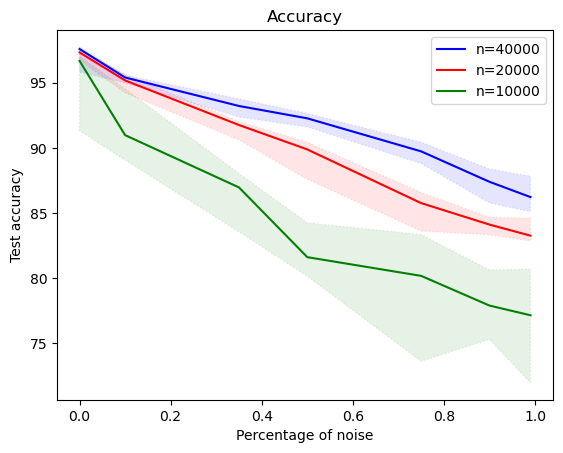

In [11]:
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th, and 90th percentiles
quantile_array = np.quantile(accuracy_test_e3, q=quantiles, axis=2)
quantile_array.shape

colors = np.array(['blue','red','green','orange'])

for i in range(n_samples.shape[0]):

    plt.plot(noise_props, quantile_array[1,i,], label = f'n={n_samples[i]*2}', 
             color=colors[i])
    plt.fill_between(noise_props, quantile_array[0,i,], quantile_array[2,i,],
                     color=colors[i],
                 alpha=0.1,linestyle='dotted')

plt.xlabel('Percentage of noise')
plt.ylabel('Test accuracy')
plt.title('Accuracy')
plt.legend()


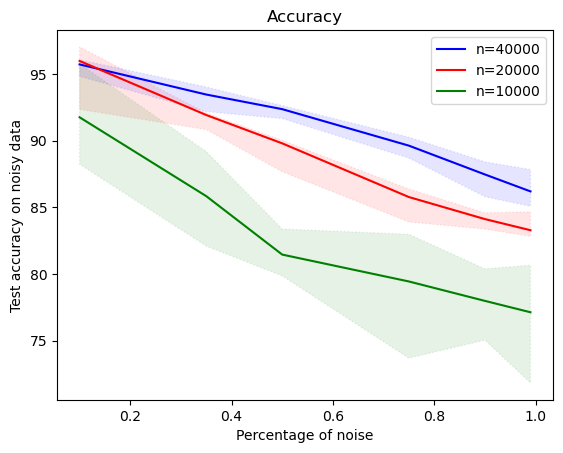

In [13]:
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th, and 90th percentiles
quantile_array = np.quantile(accuracy_noisy_test_e3, q=quantiles, axis=2)
quantile_array.shape

colors = np.array(['blue','red','green','orange'])

for i in range(n_samples.shape[0]):

    plt.plot(noise_props[1:len(noise_props)], 
             quantile_array[1,i,][1:len(noise_props)],
             label = f'n={n_samples[i]*2}', 
             color=colors[i])
    
    plt.fill_between(noise_props[1:len(noise_props)], 
                     quantile_array[0,i,][1:len(noise_props)], 
                     quantile_array[2,i,][1:len(noise_props)],
                     color=colors[i],
                     alpha=0.1, linestyle='dotted')

   
plt.xlabel('Percentage of noise')
plt.ylabel('Test accuracy on noisy data')
plt.title('Accuracy')
plt.legend()